In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import time
import datetime as dt
from pytz import timezone
tz = timezone('EST')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

In [2]:
ri2011 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2011_smd_hourly.xls")
ri2011 = pd.read_excel(ri2011, 'RI')
ri2012 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2012_smd_hourly.xls")
ri2012 = pd.read_excel(ri2012, 'RI')
ri2013 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2013_smd_hourly.xls")
ri2013 = pd.read_excel(ri2013, 'RI')
ri2014 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2014_smd_hourly.xls")
ri2014 = pd.read_excel(ri2014, 'RI')
ri2015 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2015_smd_hourly.xls")
ri2015 = pd.read_excel(ri2015, 'RI')
ri2016 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2016_smd_hourly.xls")
ri2016 = pd.read_excel(ri2016, 'RI')

In [3]:
ri2017 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2017_smd_hourly.xlsx", 'RI')
ri2018 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2018_smd_hourly.xlsx", 'RI')
ri2019 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2019_smd_hourly.xlsx", 'RI')
ri2020 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2020_smd_hourly.xlsx", 'RI')
ri2021 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2021_smd_hourly.xlsx", 'RI')
ri2022 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2022_smd_hourly.xlsx", 'RI')

In [4]:
ri2022

,Date,Hr_End,DA_Demand,RT_Demand,DA_LMP,DA_EC,DA_CC,DA_MLC,RT_LMP,RT_EC,RT_CC,RT_MLC,Dry_Bulb,Dew_Point
0,2022-01-01,1,699.2,693.413,32.42,32.35,0.23,-0.16,25.83,25.95,0.0,-0.12,45,45
1,2022-01-01,2,677.8,662.089,32.54,32.31,0.28,-0.05,25.87,25.87,0.0,0.00,45,45
2,2022-01-01,3,645.2,638.986,30.74,30.85,0.00,-0.11,27.53,27.50,0.0,0.03,45,45
3,2022-01-01,4,642.4,625.841,29.59,29.69,0.00,-0.10,25.14,25.13,0.0,0.01,45,45
4,2022-01-01,5,637.7,623.152,30.74,30.86,0.00,-0.12,29.26,29.27,0.0,-0.01,45,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2022-01-31,20,1118.3,1141.213,227.10,226.40,0.00,0.70,296.70,295.80,0.0,0.90,20,9
740,2022-01-31,21,1064.9,1101.191,203.17,202.82,0.00,0.35,264.93,264.21,0.0,0.72,19,10
741,2022-01-31,22,985.5,1046.707,183.95,183.42,0.00,0.53,252.53,251.93,0.0,0.60,17,10
742,2022-01-31,23,907.8,984.058,179.94,179.93,0.00,0.01,191.17,190.96,0.0,0.21,16,11


In [5]:
val2011 = ri2011['DEMAND']
val2012 = ri2012['DEMAND']
val2013 = ri2013['DEMAND']
val2014 = ri2014['DEMAND']
val2015 = ri2015['DEMAND']
val2016 = ri2016['RT_Demand']
val2017 = ri2017['RT_Demand']
val2018 = ri2018['RT_Demand']
val2019 = ri2019['RT_Demand']
val2020 = ri2020['RT_Demand']
val2021 = ri2021['RT_Demand']
val2022 = ri2022['RT_Demand']

In [6]:
values = [val2011, val2012, val2013, val2014, val2015, val2016, val2017, val2018, val2019, val2020, val2021, val2022]
values_df = pd.concat(values, axis=0, ignore_index=False)
values_df = values_df.reset_index()
period = len(values_df)

In [7]:
rng = pd.date_range('2011-01-01', periods=period, freq='1H')
date_df = pd.DataFrame({ 'ds': rng})
date_df = date_df.reset_index()

In [8]:
frames = [date_df, values_df]
ri_load = pd.concat(frames, axis=1, ignore_index=False)
ri_load = ri_load.rename(columns={ri_load.columns[1]: 'ds', ri_load.columns[3]: 'y'})
frames2 = [ri_load['ds'], ri_load['y']]
ri_load = pd.concat(frames2, axis=1, ignore_index=False)
ri_load

,ds,y
0,2011-01-01 00:00:00,775.000
1,2011-01-01 01:00:00,733.000
2,2011-01-01 02:00:00,702.000
3,2011-01-01 03:00:00,684.000
4,2011-01-01 04:00:00,681.000
...,...,...
97171,2022-01-31 19:00:00,1141.213
97172,2022-01-31 20:00:00,1101.191
97173,2022-01-31 21:00:00,1046.707
97174,2022-01-31 22:00:00,984.058


In [9]:
model = Prophet(
        changepoint_prior_scale=0.5, 
        seasonality_mode='multiplicative', 
        interval_width=0.95, 
    )
model.add_country_holidays(country_name='US')

In [10]:
model.fit(ri_load)

In [11]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('ri_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model

# Forecasting

In [ ]:
with open('ri_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

In [11]:
future_pd = model.make_future_dataframe(
        periods=365, 
        freq='D',
        include_history=False
    )
    
# make predictions
forecast_pd = m.predict(future_pd)

In [12]:
forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
97536,2022-02-16 00:00:00,798.123495,599.344577,993.996024
97537,2022-02-16 01:00:00,758.502063,565.280485,955.048214
97538,2022-02-16 02:00:00,735.267810,546.581224,927.245388
97539,2022-02-16 03:00:00,729.627914,529.106838,923.380495
97540,2022-02-16 04:00:00,745.894001,527.262747,945.770642


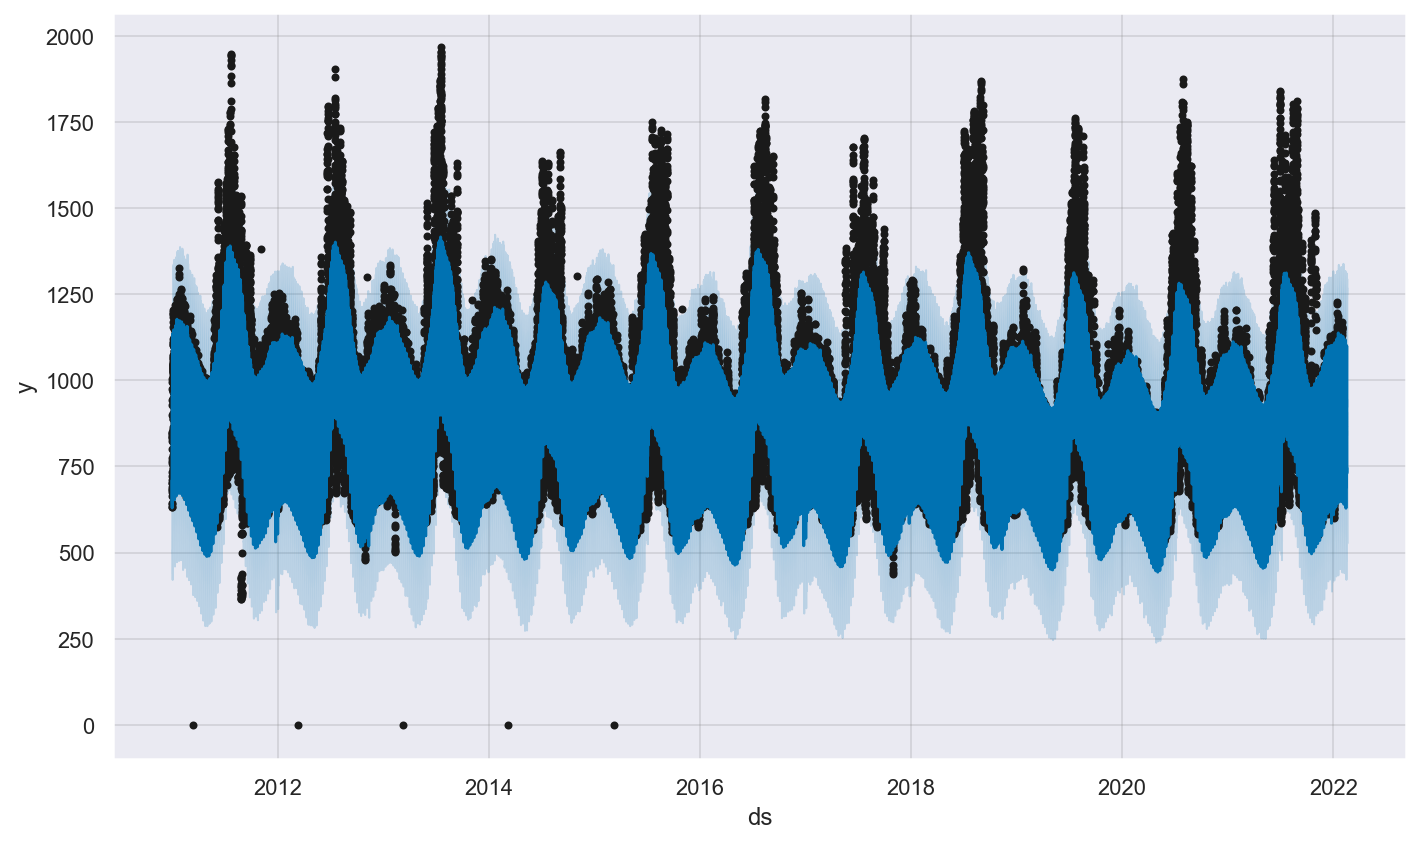

In [13]:
fig1 = model.plot(forecast_pd)

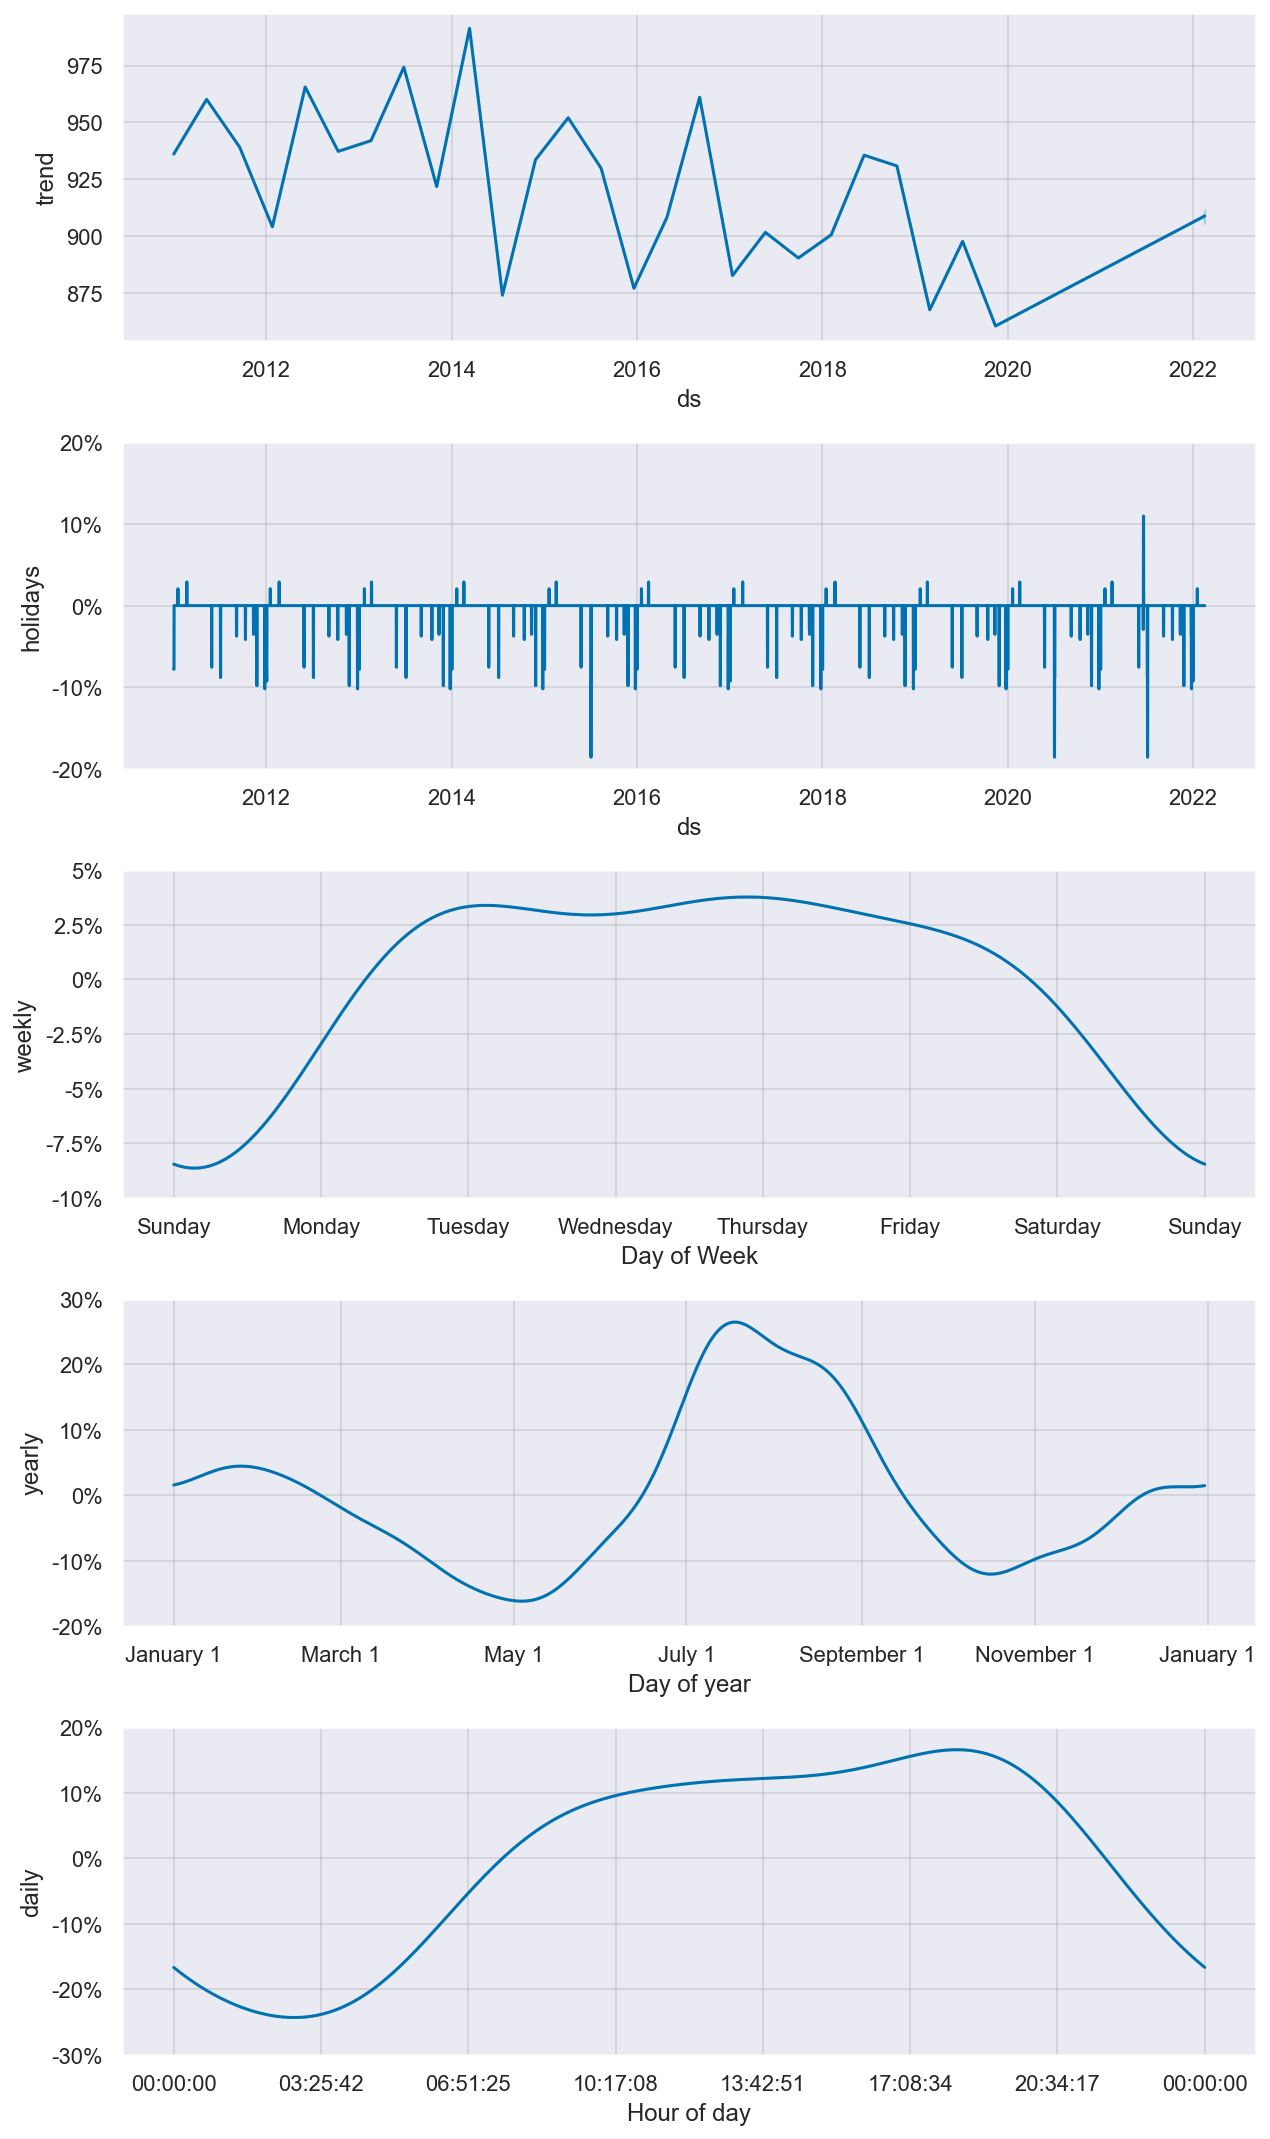

In [14]:
fig2 = model.plot_components(forecast_pd)

In [15]:
forecast_pd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01 00:00:00,936.122990,499.060706,907.386175,936.122990,936.122990,0.0,0.0,0.0,0.0,...,-0.012544,-0.012544,-0.012544,0.015185,0.015185,0.015185,0.0,0.0,0.0,709.626435
1,2011-01-01 01:00:00,936.130718,476.948914,868.036109,936.130718,936.130718,0.0,0.0,0.0,0.0,...,-0.015683,-0.015683,-0.015683,0.015220,0.015220,0.015220,0.0,0.0,0.0,665.751456
2,2011-01-01 02:00:00,936.138447,421.885007,830.431302,936.138447,936.138447,0.0,0.0,0.0,0.0,...,-0.018935,-0.018935,-0.018935,0.015254,0.015254,0.015254,0.0,0.0,0.0,638.598791
3,2011-01-01 03:00:00,936.146175,429.554392,820.737068,936.146175,936.146175,0.0,0.0,0.0,0.0,...,-0.022289,-0.022289,-0.022289,0.015289,0.015289,0.015289,0.0,0.0,0.0,629.427392
4,2011-01-01 04:00:00,936.153904,440.630758,840.178129,936.153904,936.153904,0.0,0.0,0.0,0.0,...,-0.025733,-0.025733,-0.025733,0.015324,0.015324,0.015324,0.0,0.0,0.0,642.695726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97536,2022-02-16 00:00:00,908.956471,599.344577,993.996024,905.589641,911.498232,0.0,0.0,0.0,0.0,...,0.030066,0.030066,0.030066,0.014832,0.014832,0.014832,0.0,0.0,0.0,798.123495
97537,2022-02-16 01:00:00,908.958911,565.280485,955.048214,905.576123,911.511475,0.0,0.0,0.0,0.0,...,0.030340,0.030340,0.030340,0.014736,0.014736,0.014736,0.0,0.0,0.0,758.502063
97538,2022-02-16 02:00:00,908.961350,546.581224,927.245388,905.562606,911.524718,0.0,0.0,0.0,0.0,...,0.030666,0.030666,0.030666,0.014639,0.014639,0.014639,0.0,0.0,0.0,735.267810
97539,2022-02-16 03:00:00,908.963790,529.106838,923.380495,905.549088,911.537961,0.0,0.0,0.0,0.0,...,0.031038,0.031038,0.031038,0.014543,0.014543,0.014543,0.0,0.0,0.0,729.627914


In [18]:
forecast_pd.to_csv('ri_forecast.csv', index=False)

In [19]:
import joblib
 
# Save the model as a pickle in a file
joblib.dump(model, 'ri_model.pkl')

['ri_model.pkl']